In [ ]:
import requests
from bs4 import BeautifulSoup as Bea

@staticmethod
def fetch_html(user_id):
    """
    Fetch the HTML for a user's profile page using their user_id.
    """
    url = f"https://stackoverflow.com/users/{user_id}"
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the request fails
    return Bea(response.content, "html.parser")

class Stats:
    def __init__(self, username, reputation, reached, answers, questions):
        self.username = username
        self.reputation = reputation
        self.reached = reached
        self.answers = answers
        self.questions = questions

    @staticmethod
    def _get_stats(user_id):

        # Fetch and parse HTML
        soup = fetch_html(user_id)

        # Extract attributes
        username = Stats.get_username(soup)
        reputation = Stats.get_reputation(soup)
        reached = Stats.get_reached(soup)
        answers = Stats.get_answers(soup)
        questions = Stats.get_questions(soup)

        return Stats(username, reputation, reached, answers, questions)

    @staticmethod
    def get_username(soup):

        title_element = soup.find("title")
        if title_element:
            title_text = title_element.text.strip()
            # The title typically has the format: "User {username} - Stack Overflow"
            if "User " in title_text:
                return title_text.split("User ")[1].split(" - Stack Overflow")[0]
        return None

    @staticmethod
    def get_reputation(soup):

        container = soup.find(id="stats")
        if container:
            reputation = container.find_all(class_="fs-body3")[0].text.strip()
            return int(reputation.replace(",", ""))  # Convert to integer
        return 0
    
    @staticmethod
    def get_reached(soup):

        container = soup.find(id="stats")
        if container:
            reputation = container.find_all(class_="fs-body3")[1].text.strip()
            return str(reputation.replace(",", ""))  # Convert to integer
        return 0

    @staticmethod
    def get_answers(soup):

        container = soup.find(id="stats")
        if container:
            reputation = container.find_all(class_="fs-body3")[2].text.strip()
            return str(reputation.replace(",", ""))  # Convert to integer
        return 0

    @staticmethod
    def get_questions(soup):
        container = soup.find(id="stats")
        if container:
            reputation = container.find_all(class_="fs-body3")[3].text.strip()
            return str(reputation.replace(",", ""))  # Convert to integer
        return 0

    def __repr__(self):
        return (f"Stats(username={self.username}, reputation={self.reputation}, "
                f"answers={self.answers}, questions={self.questions})")


In [ ]:
class Tags:
    def __init__(self, user_id, technology, score, post, post_per):
        self.user_id = user_id
        self.technology = technology
        self.score = score
        self.post = post
        self.post_per = post_per
    
    from bs4 import BeautifulSoup

    @staticmethod
    def _get_tags(user_id):

        soup = fetch_html(user_id)
        tags_dict = {}

        # Locate the top-tags container
        container = soup.find("div", {"id": "top-tags"})
        if container:
            # Loop through all tag sections
            for tag_section in container.find_all("div", class_="p12 bb bc-black-200"):
                # Extract the tag name
                tag_name_element = tag_section.find("a", class_="s-tag")
                tag_name = tag_name_element.text.strip() if tag_name_element else None

                # Extract the stats (score, posts, post %)
                stats_elements = tag_section.find_all("div", class_="fs-body3")
                if len(stats_elements) >= 3:
                    tag_score = stats_elements[0].text.strip().replace(",", "")
                    tag_posts = stats_elements[1].text.strip().replace(",", "")
                    tag_posts_percent = stats_elements[2].text.strip()

                    # Add to dictionary
                    tags_dict[tag_name] = (tag_score, tag_posts, tag_posts_percent)

        """
        Returns:
            dict: A dictionary where keys are tag names, and values are tuples (score, posts, post_per).
        """
        return tags_dict

    


In [ ]:
class User:
    def __init__(self, user_id, url, member_since):
        self.user_id = user_id
        self.url = url
        self.member_since = member_since

        # Rest are not initialized here, but in the respective classes
        self.stats = None
        self.tags = None
        self.collective = None
        self.badges = None
    
    def get_stats(self):
        self.stats = Stats._get_stats(self.user_id)
        return self.stats
    
    def get_tags(self):
        self.tags = Tags._get_tags(self.user_id)
        return self.tags

    def get_badges(self, user_id):
        self.badges = Badges(user_id)
 
    def __repr__(self):
        return f"User(id={self.user_id}, url={self.url}, member_since={self.member_since})"


In [61]:
user = User(user_id=6309, url="https://stackoverflow.com/users/6309", member_since="2020-01-01")

# Fetch and display stats
user_stats = user.get_stats()
user_tags = Tags._get_tags(user_id=6309)
print(user_stats)
print(user_tags)


Stats(username=VonC, reputation=1310915, answers=29734, questions=16)
{'git': ('150828', '15863', '53'), 'github': ('34249', '5929', '20'), 'docker': ('16684', '1824', '6'), 'eclipse': ('16217', '1889', '6'), 'version-control': ('14128', '1395', '5')}


Starting tag logging. Press Ctrl+C to stop.
Logged data for user 6309 at 2024-11-24 10:28:39
Stopped logging tags.
Visualizing tag trends...


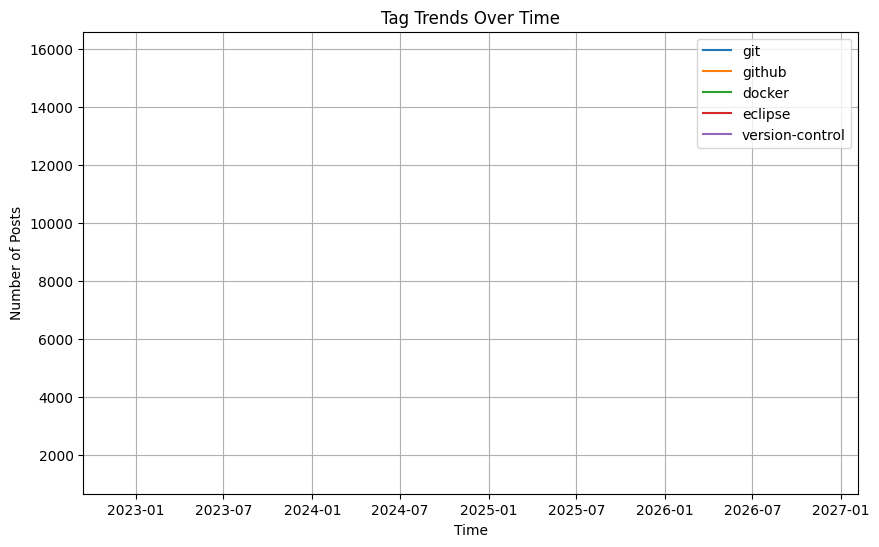

In [2]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt


# --- HTML Scraping Section ---

def fetch_html(user_id):
    """
    Fetch the HTML content of a user's Stack Overflow profile page.
    """
    url = f"https://stackoverflow.com/users/{user_id}"
    response = requests.get(url)
    response.raise_for_status()
    return BeautifulSoup(response.content, "html.parser")


def extract_tags_to_dict(soup):
    """
    Extract tags, their scores, posts, and post percentages from the parsed HTML.

    Args:
        soup (BeautifulSoup): Parsed HTML content.

    Returns:
        dict: A dictionary where keys are tag names, and values are tuples (score, posts, post_per).
    """
    tags_dict = {}

    # Locate the top-tags container
    container = soup.find("div", {"id": "top-tags"})
    if container:
        # Loop through all tag sections
        for tag_section in container.find_all("div", class_="p12 bb bc-black-200"):
            # Extract the tag name
            tag_name_element = tag_section.find("a", class_="s-tag")
            tag_name = tag_name_element.text.strip() if tag_name_element else None

            # Extract the stats (score, posts, post %)
            stats_elements = tag_section.find_all("div", class_="fs-body3")
            if len(stats_elements) >= 3:
                tag_score = stats_elements[0].text.strip().replace(",", "")
                tag_posts = stats_elements[1].text.strip().replace(",", "")
                tag_posts_percent = stats_elements[2].text.strip()

                # Add to dictionary
                tags_dict[tag_name] = (tag_score, tag_posts, tag_posts_percent)

    return tags_dict


def log_tags(user_id):
    """
    Scrape and log tag data with a timestamp for a user.

    Args:
        user_id (int): Stack Overflow user ID.
    """
    # Fetch and parse HTML
    soup = fetch_html(user_id)
    tags = extract_tags_to_dict(soup)

    # Get the current timestamp
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Save data to a CSV file
    with open(f'user_{user_id}_tags.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        for tag, stats in tags.items():
            score, posts, post_per = stats
            writer.writerow([timestamp, tag, score, posts, post_per])

    print(f"Logged data for user {user_id} at {timestamp}")


# --- Stack Overflow API Section ---

def fetch_user_tags_api(user_id, page=1):
    """
    Fetch tag activity for a Stack Overflow user using the API.

    Args:
        user_id (int): Stack Overflow user ID.
        page (int): Page number for pagination.

    Returns:
        list: A list of dictionaries containing tag data.
    """
    url = f"https://api.stackexchange.com/2.3/users/{user_id}/tags"
    params = {
        'site': 'stackoverflow',
        'page': page,
        'pagesize': 100,
        'order': 'desc',
        'sort': 'popular'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get('items', [])
    else:
        print(f"Error fetching API data: {response.status_code}")
        return []


# --- Visualization Section ---

def visualize_tag_trends(user_id):
    """
    Visualize tag trends from the logged CSV file.

    Args:
        user_id (int): Stack Overflow user ID.
    """
    # Load CSV into a DataFrame
    df = pd.read_csv(f'user_{user_id}_tags.csv', names=['timestamp', 'tag', 'score', 'posts', 'post_per'])

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Plot tag trends
    plt.figure(figsize=(10, 6))
    for tag in df['tag'].unique():
        tag_data = df[df['tag'] == tag]
        plt.plot(tag_data['timestamp'], tag_data['posts'].astype(int), label=tag)

    plt.xlabel('Time')
    plt.ylabel('Number of Posts')
    plt.title('Tag Trends Over Time')
    plt.legend()
    plt.grid()
    plt.show()


# --- Example Usage ---

if __name__ == "__main__":
    user_id = 6309  # Replace with the desired Stack Overflow user ID

    # Step 1: Log tag data periodically
    print("Starting tag logging. Press Ctrl+C to stop.")
    try:
        while True:
            log_tags(user_id)
            time.sleep(3600)  # Log every hour
    except KeyboardInterrupt:
        print("Stopped logging tags.")

    # Step 2: Visualize tag trends from the logged data
    print("Visualizing tag trends...")
    visualize_tag_trends(user_id)


In [3]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# --- HTML Scraping Section ---

def fetch_html(user_id):
    """
    Fetch the HTML content of a user's Stack Overflow profile page.
    """
    url = f"https://stackoverflow.com/users/{user_id}"
    response = requests.get(url)
    response.raise_for_status()
    return BeautifulSoup(response.content, "html.parser")


def extract_tags_to_dict(soup):
    """
    Extract tags, their scores, posts, and post percentages from the parsed HTML.

    Args:
        soup (BeautifulSoup): Parsed HTML content.

    Returns:
        dict: A dictionary where keys are tag names, and values are tuples (score, posts, post_per).
    """
    tags_dict = {}

    # Locate the top-tags container
    container = soup.find("div", {"id": "top-tags"})
    if container:
        # Loop through all tag sections
        for tag_section in container.find_all("div", class_="p12 bb bc-black-200"):
            # Extract the tag name
            tag_name_element = tag_section.find("a", class_="s-tag")
            tag_name = tag_name_element.text.strip() if tag_name_element else None

            # Extract the stats (score, posts, post %)
            stats_elements = tag_section.find_all("div", class_="fs-body3")
            if len(stats_elements) >= 3:
                tag_score = stats_elements[0].text.strip().replace(",", "")
                tag_posts = stats_elements[1].text.strip().replace(",", "")
                tag_posts_percent = stats_elements[2].text.strip()

                # Add to dictionary
                tags_dict[tag_name] = (tag_score, tag_posts, tag_posts_percent)

    return tags_dict


# --- Logging Section ---

def log_tags(user_id):
    """
    Scrape and log tag data with a timestamp for a user.

    Args:
        user_id (int): Stack Overflow user ID.
    """
    # Fetch and parse HTML
    soup = fetch_html(user_id)
    tags = extract_tags_to_dict(soup)

    # Get the current timestamp
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Save data to a CSV file
    with open(f'user_{user_id}_tags.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        for tag, stats in tags.items():
            score, posts, post_per = stats
            writer.writerow([timestamp, tag, score, posts, post_per])

    print(f"Logged data for user {user_id} at {timestamp}")


# --- Visualization Section ---

def visualize_tag_trends(user_id):
    """
    Visualize tag trends from the logged CSV file.

    Args:
        user_id (int): Stack Overflow user ID.
    """
    # Load CSV into a DataFrame
    df = pd.read_csv(f'user_{user_id}_tags.csv', names=['timestamp', 'tag', 'score', 'posts', 'post_per'])

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Plot tag trends
    plt.figure(figsize=(10, 6))
    for tag in df['tag'].unique():
        tag_data = df[df['tag'] == tag]
        plt.plot(tag_data['timestamp'], tag_data['posts'].astype(int), label=tag)

    plt.xlabel('Time')
    plt.ylabel('Number of Posts')
    plt.title('Tag Trends Over Time')
    plt.legend()
    plt.grid()
    plt.show()


# --- Interactive Logging in Jupyter ---

def start_logging(user_id, interval=3600, iterations=3):
    """
    Log tag data periodically and display updates interactively in Jupyter.

    Args:
        user_id (int): Stack Overflow user ID.
        interval (int): Time interval (in seconds) between scrapes.
        iterations (int): Number of iterations to scrape data.
    """
    print(f"Starting tag logging for user {user_id}. Logging {iterations} times every {interval} seconds.")
    for i in range(iterations):
        log_tags(user_id)
        clear_output(wait=True)
        print(f"Iteration {i + 1}/{iterations} completed.")
        if i < iterations - 1:
            print(f"Waiting for {interval} seconds...")
            time.sleep(interval)

    print("Tag logging completed.")



In [ ]:
user_id = 6309  # Replace with the desired Stack Overflow user ID
start_logging(user_id, interval=10, iterations=3)  # Logs every 10 seconds for 3 iterations


Iteration 2/3 completed.
Waiting for 10 seconds...


In [ ]:
visualize_tag_trends(user_id)